In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as teg
import netCDF4 as nc
import cmasher
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['font.family'] = 'Dejavu Serif'

In [2]:
# i/o params
loc = "/scratch/hcm7920/ambData/channelMean/"
loc2= "/scratch/hcm7920/amb0/data/"
loc3 = "/home/hcm7920/experiments/arcticMiddepthBI/plots/officialFigs/"
conc = [0,100]

# grid params
nx = 500
ny = 500
nz = 50
dy = 2000

# phys params
g = 9.81
rhoConst = 1000
cellArea = (2e3)**2
sFac = 7.4e-4 * rhoConst * -g / rhoConst # for clarity

In [3]:
# load
rhoSteady = np.load(loc+"channelMeanRho.npy")
n2Steady  = np.load(loc+"channelMeanN2.npy")
saltSteady= np.load(loc+"channelMeanSalt.npy")
uSteady   = np.load(loc+"channelMeanU.npy")
vSteady   = np.load(loc+"channelMeanV.npy")
wSteady   = np.load(loc+"channelMeanW.npy")

vsBar     = np.load(loc+"channelMeanVSbar.npy")
wsBar     = np.load(loc+"channelMeanWSbar.npy")
vrBar     = np.load(loc+"channelMeanVRbar.npy")
wrBar     = np.load(loc+"channelMeanWRbar.npy")

wsBarFlx = np.load(loc+"channelMeanAdvSltFlxZ.npy")
vsBarFlx = np.load(loc+"channelMeanAdvSltFlxY.npy")

saltForcing = np.load(loc+"channelMeanSaltForcing.npy")
UmomForcing = np.load(loc+"channelMeanUmomForcing.npy")
VmomForcing = np.load(loc+"channelMeanVmomForcing.npy")
saltTend    = np.load(loc+"channelMeanSaltTendency.npy")

diffSalt = np.load(loc+"channelMeanDiffSaltIbar.npy")
diffSalt /= cellArea

ghatSalt = np.load(loc+"channelMeanNonLocal.npy")
ghatSalt /= cellArea

levs = nc.Dataset(loc2+"grid.nc")["Z"][:]
levFaces = nc.Dataset(loc2+"grid.nc")["Zp1"][:]
deltaFaces = nc.Dataset(loc2+"grid.nc")["drF"][:]
deltaCentr = nc.Dataset(loc2+"grid.nc")["drC"][:]



In [4]:
# pad some arrays as necessary

saltSteady = np.pad(saltSteady,((0,0),(0,1),(0,0)),mode="edge")
diffSalt = np.pad(diffSalt,((0,1),(0,0),(0,0)),mode="constant",constant_values=0)
wsBarFlx = np.pad(wsBarFlx,((0,1),(0,0),(0,0)),mode="constant",constant_values=0)


In [5]:
# calculate correlation terms

wsPrimeBar = wsBarFlx[:-1,:,:]/(2e3**2) - (wSteady*saltSteady[:,:-1,:])
wsPrimeBar = np.pad(wsPrimeBar,((0,1),(0,0),(0,0)),constant_values=0)
vsPrimeBar = vsBarFlx/(2e3*deltaFaces[:,np.newaxis,np.newaxis])-(vSteady*saltSteady)


In [6]:
# divergence of eddy adv terms

term1 = (vsPrimeBar[:,1:,:]-vsPrimeBar[:,:-1,:]) / 2000
term2 = (wsPrimeBar[:-1,:,:]-wsPrimeBar[1:,:,:]) / deltaFaces[:,None,None]
divAdvFlux = -term1 - term2


In [7]:
# divergence of total adv terms

term1 = (wsBarFlx[:-1,:,:]-wsBarFlx[1:,:,:]) / (deltaFaces[:,None,None]*2e3**2)
term2 = (vsBarFlx[:,1:,:]-vsBarFlx[:,:-1,:]) / (deltaFaces[:,None,None]*2e3**2)
divTotAdvFlux = -term1 - term2


In [8]:
# divergence of dif terms

divDiffFlux = -(diffSalt[:-1,:,:]-diffSalt[1:,:,:]) / deltaFaces[:,None,None]


In [9]:
# grid array

yRange = np.linspace(-500,500,500)


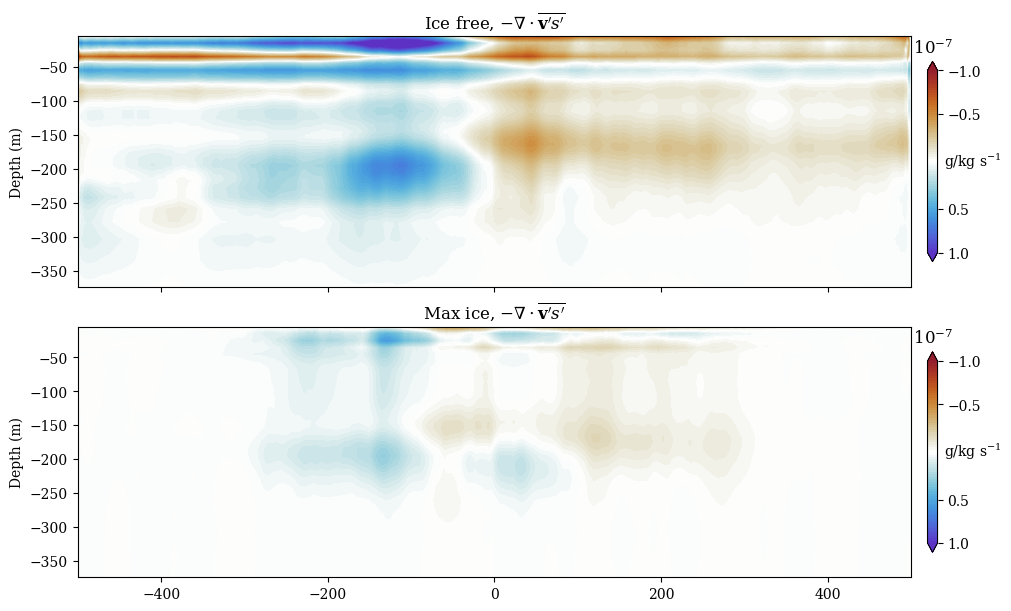

In [10]:
# make the official figure

dI = 29
myMax = abs(divAdvFlux[:,:,0]).max()*1e7
myLevs = np.linspace(-myMax,myMax,75)*0.75

myCmap = cmasher.cm.fusion
myCmap = cmasher.get_sub_cmap(myCmap,0.15,0.85)
fig,ax = plt.subplots(2,1,sharex=True,
                      layout="constrained",figsize=(10,6))

im1 = ax[0].contourf(yRange,levs[:dI],divAdvFlux[:dI,:,0]*1e7,myLevs,
                    cmap=myCmap,extend="both")
ax[0].set_ylabel("Depth (m)")
ax[0].set_title("Ice free, "+r"$-\nabla\cdot\overline{\mathbf{v}'s'}$")
cbar1 = plt.colorbar(im1,shrink=0.8,pad=0.02,ticks=[-1,-.5,.5,1])
cbar1.ax.set_title(r"$\,{10}^{-7}$")
cbar1.ax.invert_yaxis()
cbar1.ax.set_ylabel(r"$\mathrm{g}/\mathrm{kg}\,\,\mathrm{s}^{-1}$",
                    rotation=0,labelpad=-6,y=0.56)

im2 = ax[1].contourf(yRange,levs[:dI],divAdvFlux[:dI,:,-1]*1e7,myLevs,
                    cmap=myCmap,extend="both")
ax[1].set_ylabel("Depth (m)")
ax[1].set_title("Max ice, "+r"$-\nabla\cdot\overline{\mathbf{v}'s'}$")
cbar2 = plt.colorbar(im2,shrink=0.8,pad=0.02,ticks=[1,.5,-.5,-1])
cbar2.ax.set_title(r"$\,{10}^{-7}$")
cbar2.ax.invert_yaxis()
cbar2.ax.set_ylabel(r"$\mathrm{g}/\mathrm{kg}\,\,\mathrm{s}^{-1}$",
                    rotation=0,labelpad=-6,y=0.56)


plt.savefig(loc3+"figAdvectiveFluxSection.pdf", bbox_inches="tight")

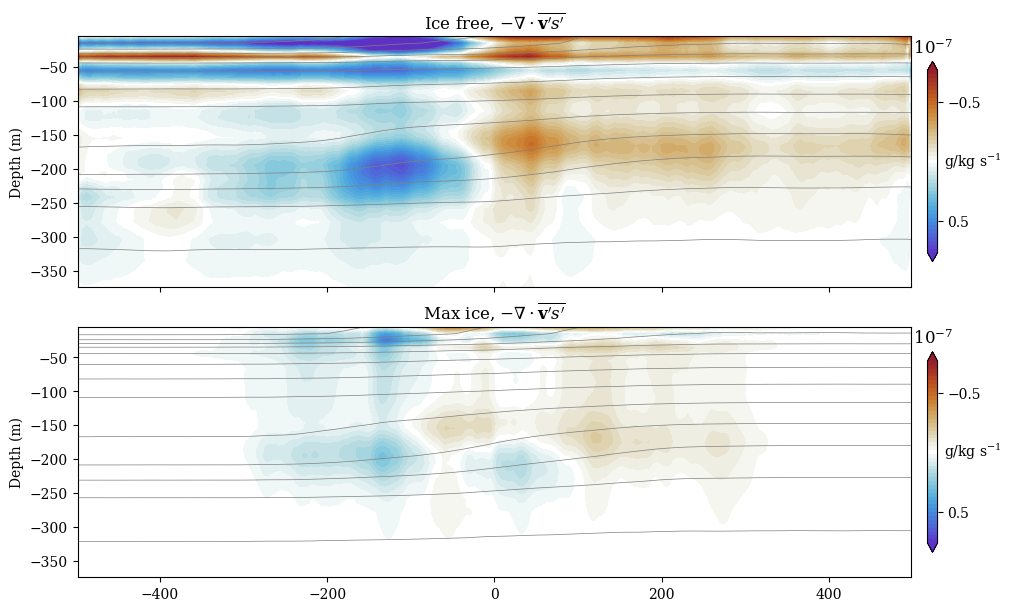

In [11]:
# same image with overlaid density contours

dI = 29

fig,ax = plt.subplots(2,1,sharex=True,
                      layout="constrained",figsize=(10,6))

myMax = abs(divAdvFlux[:,:,0]).max()*1e7
myLevs = np.linspace(-myMax,myMax,48)*0.60
saltMax = saltSteady[1:,1:-2,0].max().round()
saltMin = saltSteady[1:,1:-2,0].min().round()
saltDif = (saltMax - saltMin).astype(int)
saltLevs = np.linspace(saltMin,saltMax,1+2*saltDif)

im1 = ax[0].contourf(yRange[1:-1],levs[:dI],divAdvFlux[:dI,1:-1,0]*1e7,myLevs,
                    cmap=myCmap,extend="both")
ax[0].contour(yRange[1:-1],levs[:dI],saltSteady[:dI,1:-2,0],saltLevs,
              colors="grey",linewidths=0.5)
ax[0].set_ylabel("Depth (m)")
ax[0].set_title("Ice free, "+r"$-\nabla\cdot\overline{\mathbf{v}'s'}$")
cbar1 = plt.colorbar(im1,shrink=0.8,pad=0.02,ticks=[-.5,.5])
cbar1.ax.set_title(r"$\,{10}^{-7}$")
cbar1.ax.invert_yaxis()
cbar1.ax.set_ylabel(r"$\mathrm{g}/\mathrm{kg}\,\,\mathrm{s}^{-1}$",
                    rotation=0,labelpad=-6,y=0.56)

im2 = ax[1].contourf(yRange[1:-1],levs[:dI],divAdvFlux[:dI,1:-1,-1]*1e7,myLevs,
                    cmap=myCmap,extend="both")
ax[1].contour(yRange[1:-1],levs[:dI],saltSteady[:dI,1:-2,-1],saltLevs,
              colors="grey",linewidths=0.5)
ax[1].set_ylabel("Depth (m)")
ax[1].set_title("Max ice, "+r"$-\nabla\cdot\overline{\mathbf{v}'s'}$")
cbar2 = plt.colorbar(im2,shrink=0.8,pad=0.02,ticks=[-.5,.5])
cbar2.ax.set_title(r"$\,{10}^{-7}$")
cbar2.ax.invert_yaxis()
cbar2.ax.set_ylabel(r"$\mathrm{g}/\mathrm{kg}\,\,\mathrm{s}^{-1}$",
                    rotation=0,labelpad=-6,y=0.56)

plt.savefig(loc3+"figAdvectiveFluxSection-addContours.pdf", bbox_inches="tight")

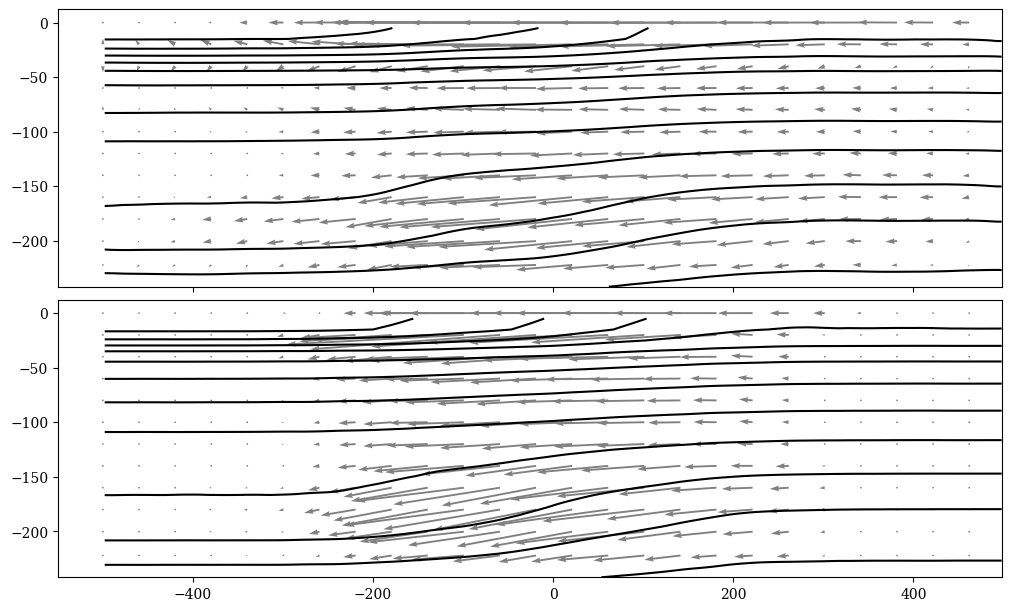

In [12]:
# section of eddy flux vector field

dI = 24

fig,ax = plt.subplots(2,1,sharex=True,
                      layout="constrained",figsize=(10,6))

saltMax = saltSteady[1:,1:-2,0].max().round()
saltMin = saltSteady[1:,1:-2,0].min().round()
saltDif = (saltMax - saltMin).astype(int)
saltLevs = np.linspace(saltMin,saltMax,1+2*saltDif)

ax[0].contour(yRange[1:-1],levs[:dI],saltSteady[:dI,1:-2,0],saltLevs,
              colors="black",linewidths=1.5)
ax[1].contour(yRange[1:-1],levs[:dI],saltSteady[:dI,1:-2,-1],saltLevs,
              colors="black",linewidths=1.5)

ax[0].quiver(yRange[::20],levFaces[:dI:2],vsPrimeBar[:dI:2,:-1:20,0]/1000,wsPrimeBar[:dI:2,::20,0],pivot='tail',width=0.002,color='grey')
ax[1].quiver(yRange[::20],levFaces[:dI:2],vsPrimeBar[:dI:2,:-1:20,-1]/1000,wsPrimeBar[:dI:2,::20,-1],pivot='tail',width=0.002,color='grey')

In [14]:
adiaFlux = np.load(loc+"channelMeanAdiaAdvFlux.npy")
diabaticFlux = np.load(loc+"channelMeanDiabaticAdvFlux.npy")

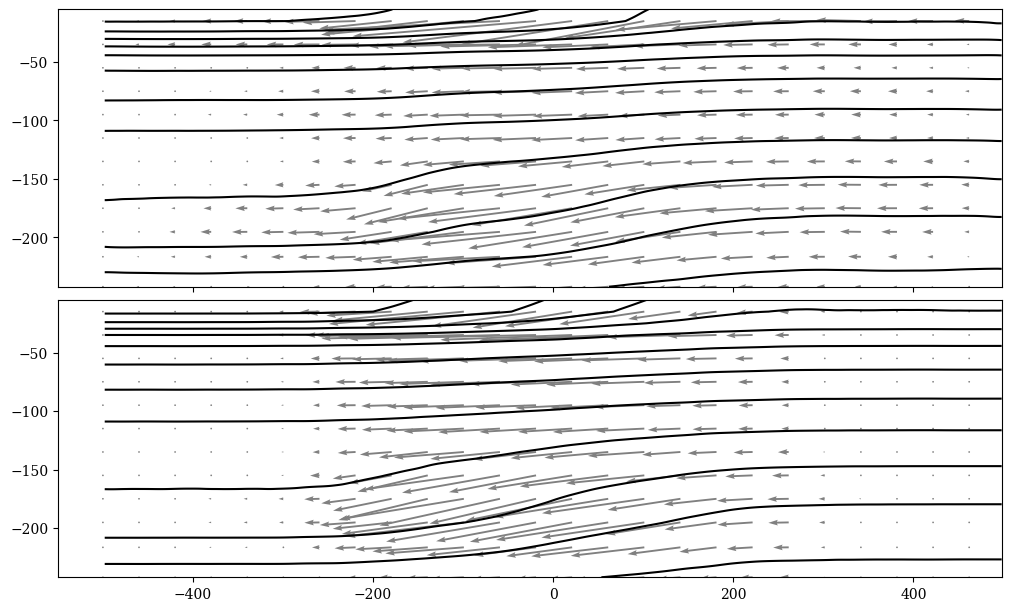

In [17]:
# section of adiabatic part

sI = 1
dI = 24

fig,ax = plt.subplots(2,1,sharex=True,
                      layout="constrained",figsize=(10,6))

saltMax = saltSteady[1:,1:-2,0].max().round()
saltMin = saltSteady[1:,1:-2,0].min().round()
saltDif = (saltMax - saltMin).astype(int)
saltLevs = np.linspace(saltMin,saltMax,1+2*saltDif)

ax[0].contour(yRange[1:-1],levs[:dI],saltSteady[:dI,1:-2,0],saltLevs,
              colors="black",linewidths=1.5)
ax[1].contour(yRange[1:-1],levs[:dI],saltSteady[:dI,1:-2,-1],saltLevs,
              colors="black",linewidths=1.5)

ax[0].quiver(yRange[::20],levs[sI:dI:2],
             adiaFlux[0,sI:dI:2,:-1:20,0]/1000,adiaFlux[1,sI:dI:2,::20,0],
             pivot='tail',width=0.002,color='grey')
ax[1].quiver(yRange[::20],levs[sI:dI:2],
             adiaFlux[0,sI:dI:2,:-1:20,-1]/1000,adiaFlux[1,sI:dI:2,::20,-1],
             pivot='tail',width=0.002,color='grey')

In [ ]:
# section of vsPrimeBar

dI = 24
myCmap = cmasher.cm.fusion_r
myCmap = cmasher.get_sub_cmap(myCmap,0.15,0.85)

fig,ax = plt.subplots(2,1,sharex=True,
                      layout="constrained",figsize=(10,6))

saltMax = saltSteady[1:,1:-2,0].max().round()
saltMin = saltSteady[1:,1:-2,0].min().round()
saltDif = (saltMax - saltMin).astype(int)
saltLevs = np.linspace(saltMin,saltMax,1+2*saltDif)
myMax = vsPrimeBar.max()
myMin = vsPrimeBar.min()
myMin2= vsPrimeBar[:,:,-1].min()
myLevs = np.linspace(-1,1,50)

im0 = ax[0].contourf(yRange,levs[:dI],vsPrimeBar[:dI,:-1,0]/myMin*2,myLevs,
                    cmap=myCmap,extend='both')

im1 = ax[1].contourf(yRange,levs[:dI],vsPrimeBar[:dI,:-1,-1]/myMin2,myLevs,
                    cmap=myCmap,extend='both')

cbar2 = plt.colorbar(im0,shrink=0.8,pad=0.02)
cbar2 = plt.colorbar(im1,shrink=0.8,pad=0.02)


In [ ]:
# verify the gridding is correct here. maybe some interpolation is necessary
# calculate eddy streamfunction

DsaltDy = (saltSteady[:,1:,:]-saltSteady[:,:-1,:]) / dy
DsaltDz = (-saltSteady[1:,:,:]+saltSteady[:-1,:,:]) / deltaCentr[1:-1,None,None]

eddyPsi1 = -wsPrimeBar[:-1,:,:] / DsaltDy
eddyPsi2 = vsPrimeBar[:-1,:,:] / DsaltDz



In [ ]:
# eddy streamfunction

dI = 35

fig,ax = plt.subplots(2,1,sharex=True,
                      layout="constrained",figsize=(10,6))

saltMax = saltSteady[1:,1:-2,0].max().round()
saltMin = saltSteady[1:,1:-2,0].min().round()
saltDif = (saltMax - saltMin).astype(int)
saltLevs = np.linspace(saltMin,saltMax,1+2*saltDif)

ax[0].contour(yRange[1:-1],levs[:dI],saltSteady[:dI,1:-2,0],saltLevs,
              colors="grey",linewidths=0.5)
ax[1].contour(yRange[1:-1],levs[:dI],saltSteady[:dI,1:-2,-1],saltLevs,
              colors="grey",linewidths=0.5)

ax[0].contour(yRange[1:-1],levs[:dI],eddyPsi2[:dI,1:-2,0],25)
ax[1].contour(yRange[1:-1],levs[:dI],eddyPsi2[:dI,1:-2,-1],25)



In [ ]:
deltaCentr